# Wheelchair Control

![](images/wheelchair.jpg)

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Wheelchair Planar Model
================================

### Introduction

We consider a simple model of a wheelchair evolving in the plane. It is mainly made of

  - A frame ; from above, its most visible component is the seat. We assume that it is a square,

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the seat. 
    
We assume that the seat backrest is on top of the wheels common axis.


Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the wheelchait faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the wheelchair moves forward.

### Parameter Definition

From now on, we assume that the seat side length is $L = 50 \mbox{ cm}$ and the wheel radius is $R_w = 30 \mbox{ cm}$.

🧩 Define the corresponding Python variables `L` and `Rw` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
# 🔓
L = 50 / 100
Rw = 30 / 100

### Graphical Representation

🧩 Implement a function `draw_wheelchair` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with seat and fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. 

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
# 🔓
def draw_wheelchair(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)], 
        [sin(theta),  cos(theta)]
    ])

    # Seat
    corners = [[0, -L/2], [L, -L/2], [L, +L/2], [0, L/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="#868e96", zorder=10)
    
    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-Rw], [-L/2]] + translation 
    wheel_left_xy_end = rotation @ [[Rw], [-L/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-Rw], [+L/2]] + translation
    wheel_right_xy_end = rotation @ [[Rw], [L/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)
    

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

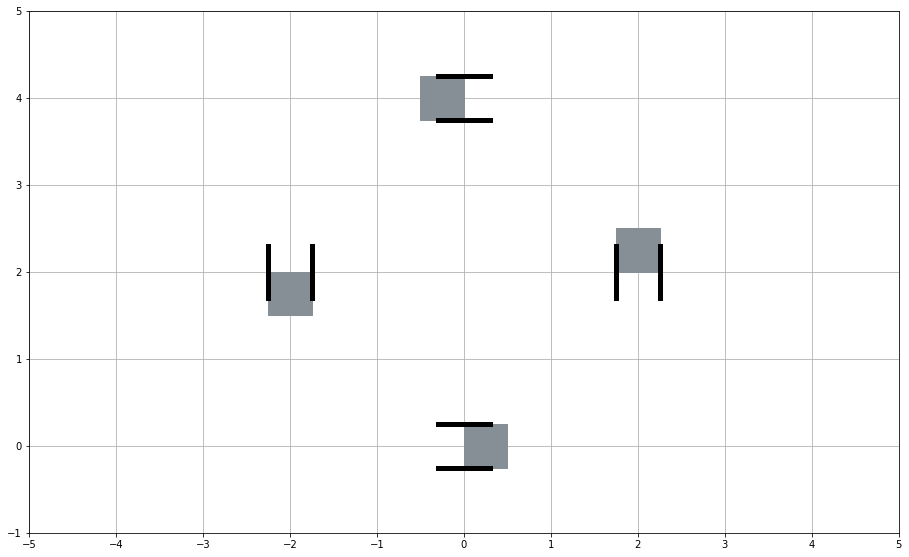

In [5]:
# 🔓
draw_arena(-5, 5, -1, 5)
draw_wheelchair(0, 0, 0)
draw_wheelchair(2, 2, pi/2)
draw_wheelchair(0, 4, pi)
draw_wheelchair(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

🔓
$$
\begin{array}{rcl}
\dot{x} &=& R_w  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R_w  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R_w  \frac{\omega_r - \omega_l}{L} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

🔓 The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

🔓 When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 (L/R_w)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - L/4) * pi / Rw
    omega_r = (1 + L/4) * pi / Rw
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [7]:
# 🔓
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = Rw * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = Rw * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = Rw * (omega_r - omega_l) / L
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - L/4)  \pi / R \mbox{ rad/s}$ and $\omega_r = (1 + L/4)  \pi / R_w \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [8]:
# 🔓
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

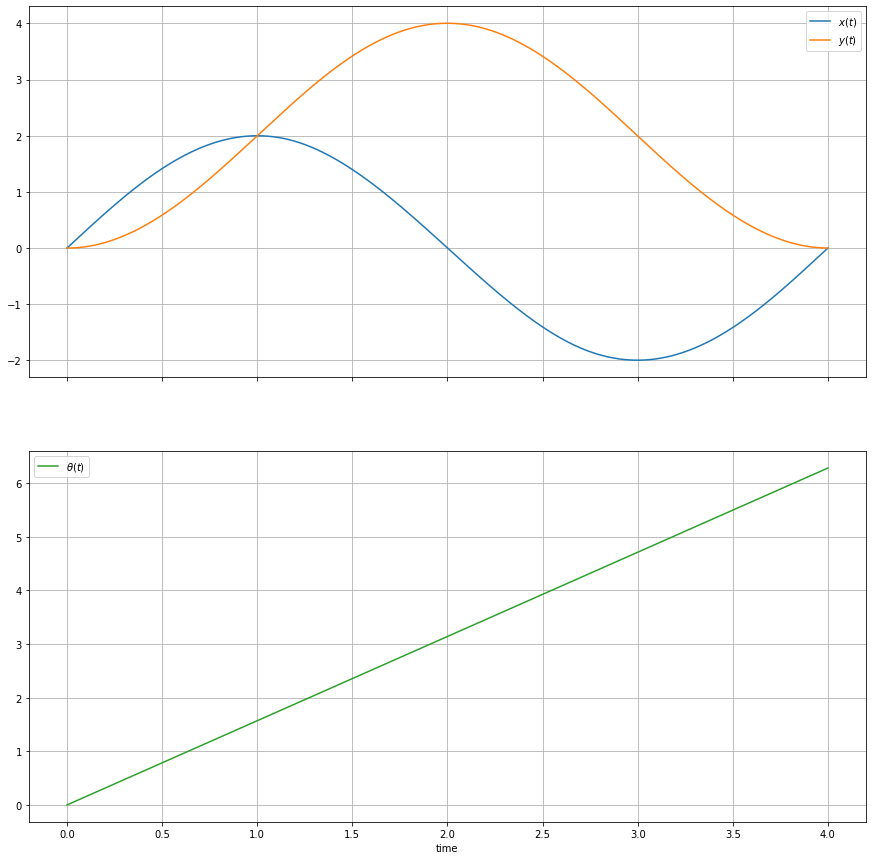

In [9]:
# 🔓
t = linspace(0.0, 4.0, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

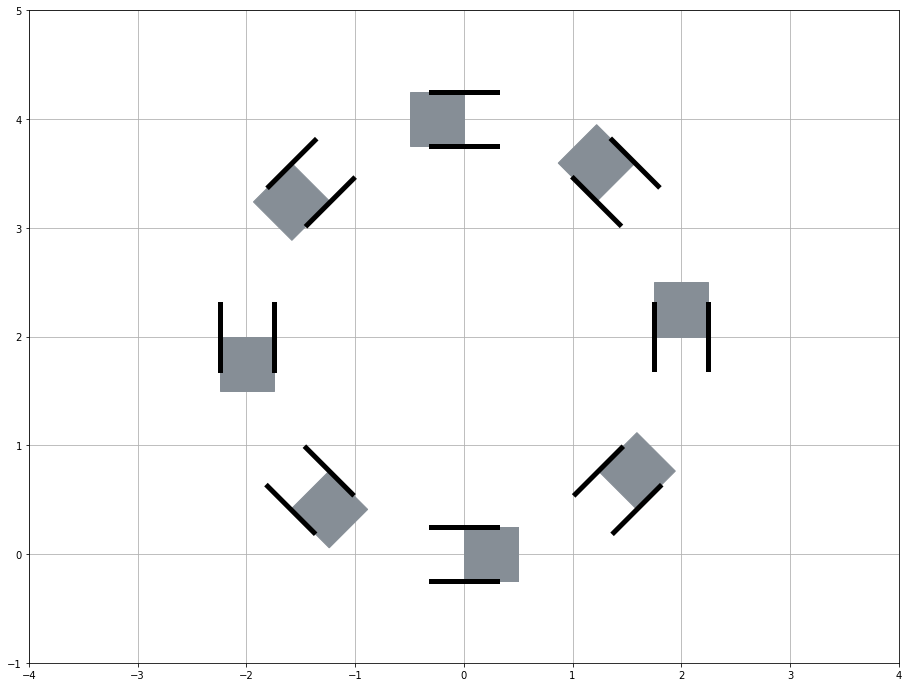

In [10]:
# 🔓
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

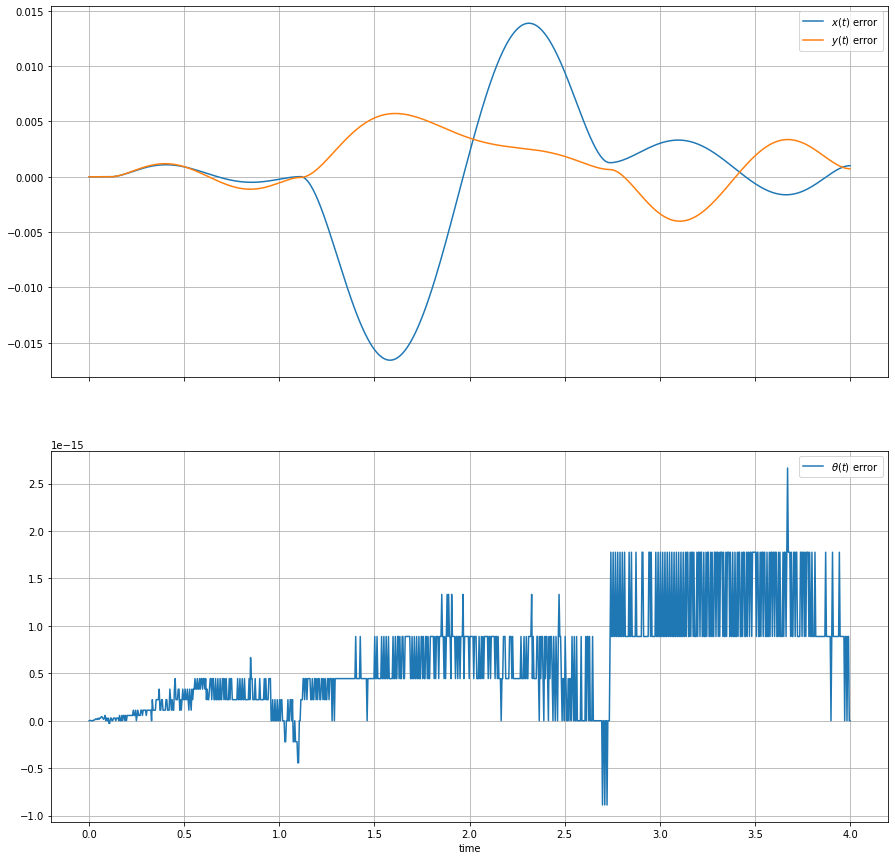

In [11]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $2 \times 10^{-5}$ for every component of $(x, y, \theta)$.

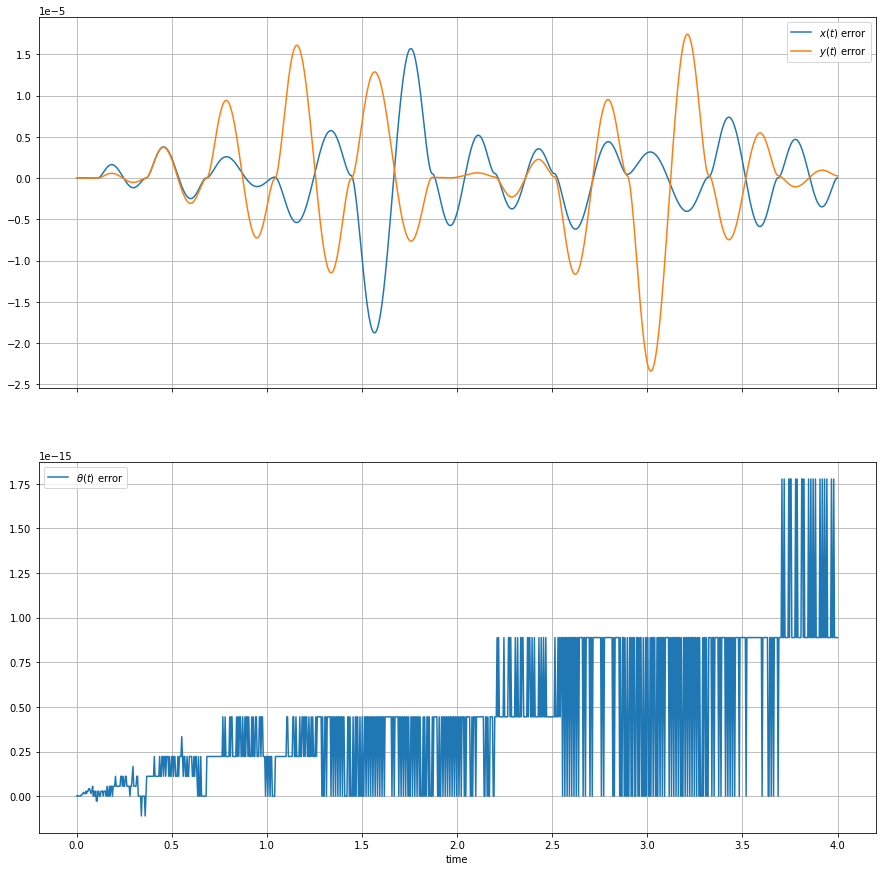

In [12]:
r = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6, 
    atol=1e-12, 
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

Step 2 - Control Implementation
===============================

Time dependent inputs
---------------------

We are going to simulate the case of the chariot controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 
We want a simulation lasting 5 seconds with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{rl}
           (1 - L/4) \pi / R_w & \mbox{when $t \leq 1s$ or $t \geq 3$,} \\
           (1 + L/4) \pi / R_w & \mbox{otherwise.}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{rl}
           (1 + L/4) \pi / R_w & \mbox{when $t \leq 1s$ or $t \geq 3$,} \\
           (1 - L/4) \pi / R_w & \mbox{otherwise.}
       \end{array}
    \right.
$$

##### 🧩 Provide the new definition of `omega`

In [13]:
# 🔓
def omega(t, xytheta):
    if t <= 1 or t >= 3:
        omega_l = (1 - L/4) * pi / Rw
        omega_r = (1 + L/4) * pi / Rw
    else:
        omega_l = (1 + L/4) * pi / Rw
        omega_r = (1 - L/4) * pi / Rw
    return array([omega_l, omega_r])

##### 🧩 Make a simulation of 4 sec of the robot with the previous input. Use the `rtol` and `atol` that used to guarantee a precision of $2 \times 10^{-5}$ and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** It is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`.  

In [14]:
# 🔓
tf = 4
r = solve_ivp(fun=fun,y0=[0,0,0],t_span=[0,tf], rtol=1e-6, atol=1e-12, dense_output=True)

🧩 Use the simulation results to display the robot location every 0.5 seconds.

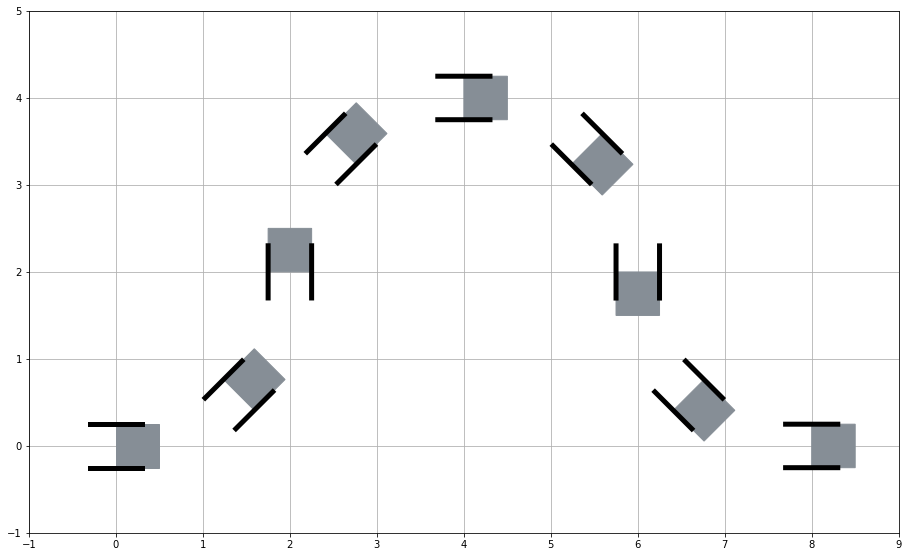

In [15]:
# 🔓
step = 0.5
t = arange(0,tf+step,step)
sol_t = r["sol"](t)
draw_arena(-1, 9, -1, 5)
for x, y, theta in sol_t.T:
    draw_wheelchair(x, y, theta)

## Analysis of the system at rest

### Equilibrium

##### 🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the wheelchair kinematic model.

🔓 **Answer.** If $\omega_e=(0,0)$, $f(X_e)=0$ ($X_e=(0,0,0)$), and so $X_e$ is an equilibrium.

##### 🧩 Show that for any other $\omega_e$, the system has no equilibrium.

🔓 **Answer.** If $\omega_l\neq 0$ or $\omega_l\neq 0$, two cases:

  1. $\omega_l\neq-\omega_r$ which is different from zero, thus $\dot{x}=\dot{y}=0$ implies $\cos\theta=\sin\theta=0$ which is impossible.
  2. $\omega_l=-\omega_r$ which is different from zero, thus $\dot{\theta} = 2\omega_r\frac RD \neq 0$

So, there is no equilibrium if $\omega \neq \omega_e$

##### 🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

🔓 **Answer.** If $\omega=\omega_e$, then $\forall X\in\mathbb{R}^3,f(X) = 0$. Every position is an equilibrium (actually, the system is at rest)

### Linearized System Model


Let $\omega = \omega_e$ and $X_e = (0,0,0)$. Let us introduce the the error variable $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$ and $\Delta \omega = \omega - \omega_e$.

##### 🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$).

🔓 **Answer.**

$$
A= \begin{bmatrix} 0 & 0 &0 \\ 0 & 0 &0 \\ 0 & 0 & 0\end{bmatrix}
$$
and
$$
B= \begin{bmatrix} \frac{R_w}{2} & \frac{R_w}{2}  \\ 0 & 0 \\ -\frac{R_w}{L} & \frac{R_w}{L} \end{bmatrix}
$$

### Stability of the linearized system

##### 🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

🔓 **Answer.** No, with the chosen $\Delta \omega$, we have $\dot X = AX$ and $A$ has three null eigenvalues. To have a positive answer, we expected each eigenvalue to have a strictly negative real part.

##### 🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

🔓 **Answer.** With $\omega = \omega_e$, the system cannot "move". If $X(t_0) = X_0$, then $\forall t>0, X(t) =X_0$. Thus, if $X_0\neq (0,0,0)$, $X(t)$ does not converge to the origin: the original system is not (even locally) attractive.

As a consequence, it is not asymptotically stable.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:

$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

🔓 **Answer.** Yes, with $\omega \propto (1,1)$, the robot will move in straight line on the (Ox) axis and will reach the origin after some time depending on the speed.

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

🔓 **Answer.** No. According to $A$ and $B$, we have $d{\Delta y}/dt=0$ and so, the error on $y$ cannot be changed by $u$.

##### 🧩 Is the linearized system controllable?

🔓 **Answer.** No, 2 possible proofs:

1. Kalman criteria: the controllability matrix has the same rank of $B$ (since $A =0$) which is 2.

2. We found that some points are not reachable with specific initial condition.

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

##### 🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

🔓 **Answer.** $y_R(t) = 0 \Rightarrow$ $\sin\theta_R = 0$ or $(\omega_l+\omega_r)/2 = 0$. The second case leads to $\dot{x}$=0 which is in contradiction with $\dot x_R = v$.
Thus, $\theta_R(t) = k\pi$. By continuity ($\theta$ cannot jump from $k\pi$ to $k'\pi$), this defines several sets of solutions in which $\theta_R(t)$ is constant and equal to $k\pi$. This leads to $\dot\theta=0$ and so $\omega_l(t)=\omega_r(t)=\omega(t)$

Finally, $\dot x = R_w\omega(t)\cos k\pi$.

We have actually 2 true sets of solutions (all the other sets will lead to the same control according to the parity of  :

1. $X_R(t) = (vt ,0, 0)$ with a reference control $\omega_R(t)=(v/R_w,v/R_w)$
1. $X_R(t) = (vt ,0, \pi)$ with a reference control $\omega_R(t)=(-v/R_w,-v/R_w)$





### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

##### 🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

🔓 **Answer.**

$$
  A = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & v \\
      0 & 0 & 0
  \end{bmatrix}
$$

and 

$$
   B=\begin{bmatrix}
    \frac{R_w}{2} & \frac{R_w}{2}  \\ 0 & 0 \\ -\frac{R_w}{L} & \frac{R_w}{L}
  \end{bmatrix}
$$

##### 🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

🔓 **Answer.** No since $A$ has 3 null eigenvalues.

##### 🧩 Is the system attractive, with $\Delta\omega(t)=0$?

🔓 **Answer.** No. Two possible justifications:
1. With an argument of the course: for linear system, locally attractive is equivalent to GAS. The system is not GAS (pprevious question).
2. By looking the system: e.g. the error $\Delta x$ remains constant without any input correction.

##### 🧩 Show that the linearized system is controllable.

🔓 **Answer.** We just study the rank of $C' = [B, AB]$ since $A^i=0$ for $i\geq2$

$$C'=
\begin{bmatrix}
    \frac{R_w}{2} & \frac{R_w}{2} & 0 & 0 \\
    0 & 0 & -v \frac{R_w}{L} & v \frac{R_w}{L} \\
    -\frac{R_w}{2} & \frac{R_w}{2} & 0 & 0
\end{bmatrix}
$$

The submatrix defined by keeping the 3 first columns if full rank. So, the controllability matrix is also full rank and the system is controllable.

### Linearized system implementation

In the sequel, we will use $v=4.8 \mbox{ km/h}$.

##### 🧩 Implement and print the matrices $A$ and $B$

In [16]:
v = 4.8 / 3.6
A = array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = array([[Rw/2, Rw/2], [0, 0], [-Rw/L, Rw/L]])
print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         1.33333333]
 [0.         0.         0.        ]]
[[ 0.15  0.15]
 [ 0.    0.  ]
 [-0.6   0.6 ]]


The linear model has to be fed with some $\Delta\omega$ input. Like for the nonlinear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we set:

In [17]:
def deltaOmega(t, deltaX):
    return array([0, 0, 0])

##### 🧩 Using this function `deltaOmega`, define a function `lin_fun` that computes $d{\Delta X}/dt$ given the arguments `t` and `deltaX`$.

In [18]:
# 🔓
def lin_fun(t, deltaX):
    return A @ deltaX + B @ deltaOmega(t, deltaX)

### Controller Design on the linearized system

##### 🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. 

For this question, we will chose 3 real poles close to -0.5.

Then, print the poles of the closed-loop system

$$
\frac{d\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [19]:
# 🔓
poles = [-0.50, -0.51, -0.52]  # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix
print(K)
e,_ = eig(A - B @ K)
print(e)

[[ 1.69999996 -0.16144726 -0.84727433]
 [ 1.70000003  0.16355274  0.85272567]]
[-0.51+0.j -0.52+0.j -0.5 +0.j]


##### 🧩 Simulate the linearized system during 20s, with the initial condition $\Delta X(0) = (0,2,0)$.

In [20]:
def deltaOmega(t,deltaX):
    return -K @ deltaX

tf = 20
r = solve_ivp(
    fun=lin_fun, 
    t_span=[0, tf], 
    y0=[0, 2, 0], 
    dense_output=True, 
    rtol=1e-6, 
    atol=1e-12
)

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

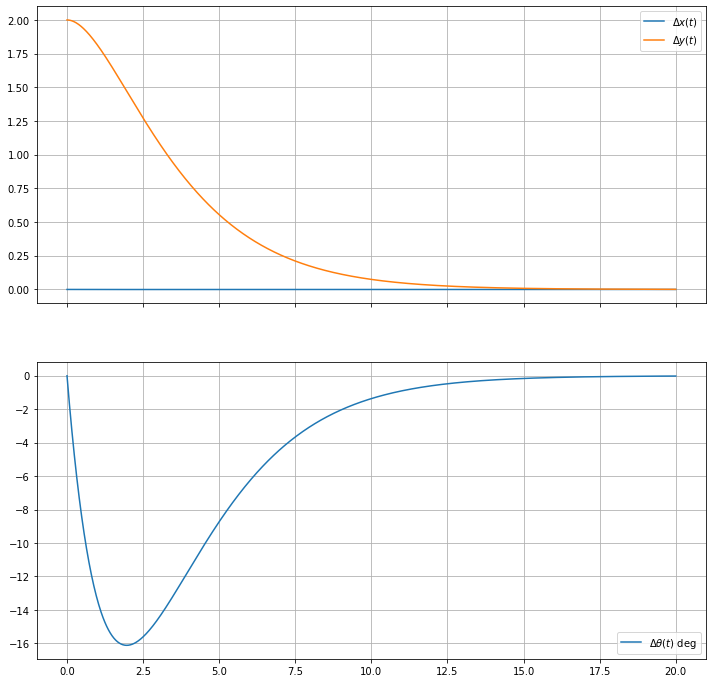

In [21]:
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
None

##### 🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

🔓 **Answer.** The heading angle is the source of non linearity. To preserve the quality of the linearization, it is important that the error is small.

##### 🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [22]:
dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]

##### 🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

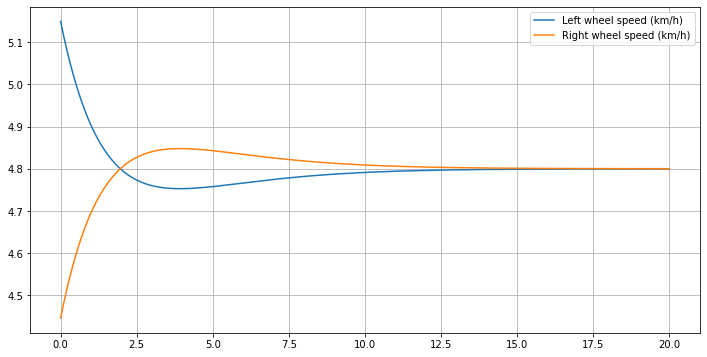

In [23]:
omega_l = dOmega_l + v/Rw
omega_r = dOmega_r + v/Rw
fig = figure(figsize=(12, 6))
plot(t, omega_l * Rw * 3.6, label=r"Left wheel speed (km/h)")
plot(t, omega_r * Rw * 3.6, label=r"Right wheel speed (km/h)")
grid()
legend()
pass

##### 🧩 Are these control values consistent with what the robot should do to cancel the error?

🔓 **Answer.** If there is not any error, the target speed of both wheels is 4.8 km/h. This is the value to which $\omega_l$ and $\omega_r$ seem to converge. At the beginning, the robot is a little bit too high ($y>0$), so it has to turn right. To do this, the left wheel has to be faster than the right one. This is effectively what we observes, and both values are around 4.8 km/h.



###  Controller Tuning



##### 🧩 Tune the poles (and recompute the gain matrix) so that the actual location $(x, y)$ is within 10 cm of the desired location within 20 sec and the linear velocity of each wheel never exceeds $5$ km/h. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

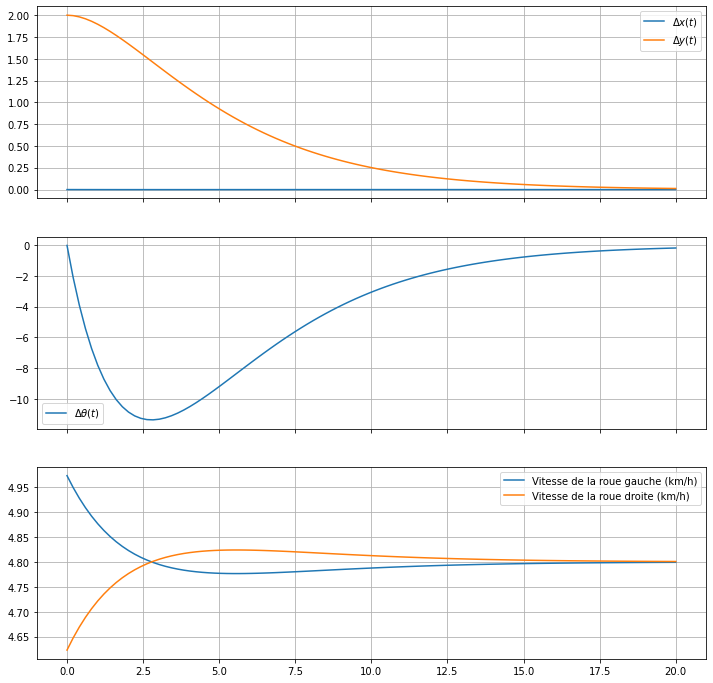

In [24]:

poles = [-0.36,-0.35,-0.37] # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix

t2 = 20
r = solve_ivp(fun=lin_fun,t_span=[0,t2],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

t = linspace(0.0,t2, 100)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(12, 12))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]
omega_l = dOmega_l +v/Rw
omega_r = dOmega_r +v/Rw

ax3.plot(t,omega_l*Rw*3.6, label=r"Vitesse de la roue gauche (km/h)")
ax3.plot(t,omega_r*Rw*3.6, label=r"Vitesse de la roue droite (km/h)")
ax3.legend()
ax3.grid()


Step 3 - Optimal control, Global Control and General Trajectories
=================================================================


###  Optimal control

In this part we aim to design a stabilizing controller using an optimal control methodology. 

We still want to follow the reference trajectoy $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$ and will work with the linearized system 

$$
\frac{d\Delta X}{dt}= A\Delta X + B\Delta\omega
$$

We want to find the control input $\Delta\omega$ that minimizes the quantity $J$ defined by

$$
J=\int_0^{t_f} q_1(\Delta x(t))^2 + q_2(\Delta y(t))^2 + q_3(\Delta \theta(t))^2+ r_1(\Delta \omega_l(t))^2+ r_2(\Delta \omega_r(t))^2 dt
$$

where the different constant $q_i$ and $r_i$ are strictly positive. We will denote 
$$
Q=\begin{bmatrix}
      q_1 & 0 & 0 \\
      0 & q_2 & 0 \\
      0 & 0 & q_3
  \end{bmatrix}
$$
and
$$
R_0=\begin{bmatrix}
      r_1 & 0 \\
      0 & r_2 \\
  \end{bmatrix}
$$

🧩 Implement a function `Compute_cost` that computes the function $J$ for a given set of matrices $Q$ and $R$, a time horizon $t=[0,t_f]$, and for the corresponding functions $\Delta X$ and $\Delta \omega$ .
To compute the integral, you can use the function `quad` (https://docs.scipy.org/doc/scipy/tutorial/integrate.html). You may need an intermediate function that returns the quantity
$$
q_1(\Delta x(t))^2 + q_2(\Delta y(t))^2 + q_3(\Delta \theta(t))^2+ r_1(\Delta \omega_l(t))^2+ r_2(\Delta \omega_r(t))^2
$$

In [25]:

r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

t=linspace(0,tf,1000)



In [26]:
from scipy import integrate
from scipy.integrate import quad

def Compute_cost (deltaX, deltaOmega):
    def f(t):
        
        delta_x, delta_y, delta_theta = deltaX(t)
        delta_omega_l, delta_omega_r = deltaOmega(t)
        q0 = Q[0][0]
        q1 = Q[1][1]
        q2 = Q[2][2]
        r1 = R0[0][0]
        r2 = R0[1][1]
        equ = q0 * delta_x**2 + q1 * delta_y**2 + q2 * delta_theta**2 + r1 * delta_omega_l**2 + r2 * delta_omega_r**2
        
        return equ

    J, e = quad(f, 0, tf)
    return J

🧩 Test the function `Compute_cost`  with the controller you designed in the Section 'Controller Tuning' when $q_i=1$ and $r_i=1$ ($t_f=20$).

In [27]:
def deltaX(t):
    return r["sol"](t)

def deltaOmega(t):
    return -K@r["sol"](t) 

Q = array([[1,0,0],[0,1,0],[0,0,1]])
R0 = array([[1,0],[0,1]])
tf=20

Compute_cost(deltaX, deltaOmega)

14.1359570604611

🧩 Multiply by 10 the poles and test the function `Compute_cost` in this new case. Interpret the results. 

In [28]:
new_poles=[i*10 for i in poles]
K = place_poles(A,B,new_poles).gain_matrix
def deltaX(t):
    return r["sol"](t)

def deltaOmega(t):
    return -K@r["sol"](t) 
Compute_cost(deltaX, deltaOmega)

1558.0999074128317

#### ANSWER

La valeur de J a augmenté, ce qui suggère que le contrôleur n'est pas aussi performant pour réduire la fonction de coût lorsque les pôles sont multipliés par 10. Cette augmentation peut être expliquée par le fait que le contrôleur plus agressif génère plus d'oscillations et de dépassements dans le système, conduisant ainsi à un coût plus élevé.


🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system such that the quantity $J$ is minimum with "$t_f=+\infty$".

Then, for $q_i=1$, $r_i=1$, print the poles of the closed-loop system:

$$
\frac{\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [29]:
from scipy import linalg
Q=[[1,0,0],[0,1,0],[0,0,1]]
R0=[[1,0],[0,1]]
S = linalg.solve_continuous_are(A, B, Q, R0)
K = inv(R0) @ B.T @ S
eigenvalues, _ = eig(A - B @ K)
print("Minimum J for Gain Matrix K  :", K)
print([[real(s),imag(s)] for s in eigenvalues])

Minimum J for Gain Matrix K  : [[ 0.70710678 -0.70710678 -1.43921798]
 [ 0.70710678  0.70710678  1.43921798]]
[[-0.863530789809625, 0.6210357678501611], [-0.863530789809625, -0.6210357678501611], [-0.21213203435596428, 0.0]]


🧩 Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h). Compute the value of the cost for $t_f=20$. Compare with the control law you obtained by pole assignment. Intepret the results.

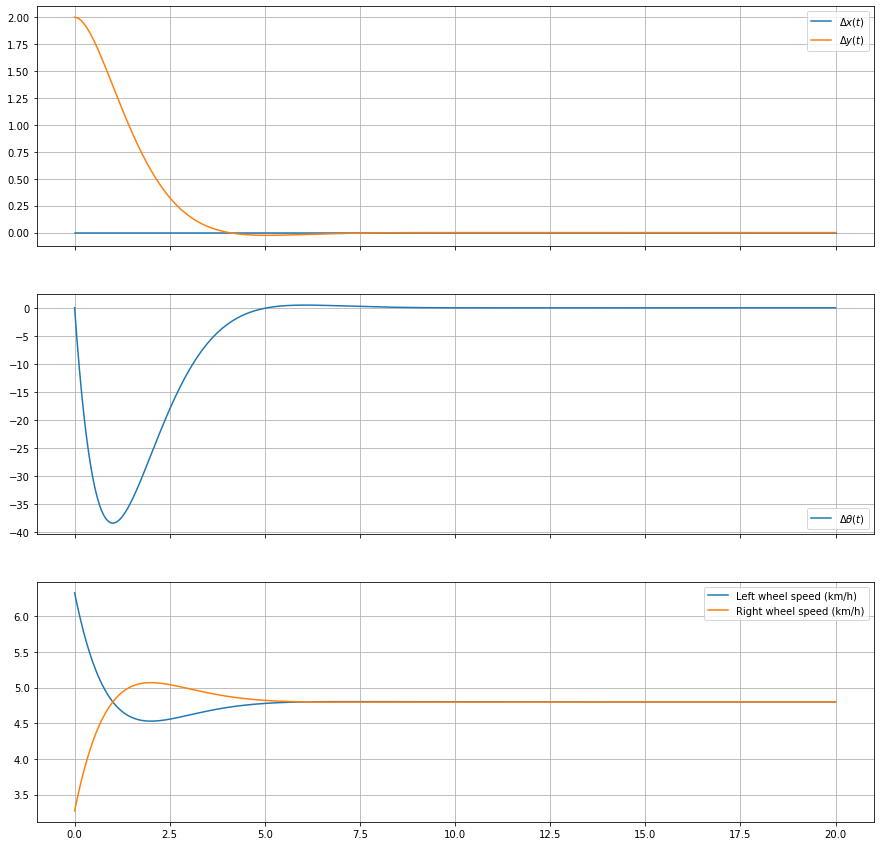

In [30]:

tf = 20
def deltaOmega(t,deltaX):
    return -K@deltaX
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l +v/Rw
omega_r = dOmega_r +v/Rw

ax3.plot(t,omega_l*Rw*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t,omega_r*Rw*3.6, label=r"Right wheel speed (km/h)")
ax3.legend()
ax3.grid()



🧩 Try large values of $Q$ then large values of $R$ and explain how these choices influence the control effort as well as the convergence speed. Do you think that both strategies will perform similarly when applied to the wheelchair nonlinear model? Then select $Q$ and $R$ to ensure that the wheel velocity nevers exceeds 5 km/h and that $x$ and $y$ have less than 10 cm error after 20 sec. 

--> Avec des valeurs plus élevées de Q, nous avons tendance à accorder plus de poids à l'erreur due aux termes de position dans la fonction de coût, ce qui pousse alors le contrôleur à préférer un effort de contrôle accru avec une vitesse de convergence plus élevée. 

D'un autre côté, des valeurs plus élevées de R accordent plus de poids aux variables de contrôle dans la fonction de coût, ce qui implique moins d'effort de contrôle (et donc des vitesses de roues plus faibles) et une vitesse de convergence plus lente.

Pour le système non linéaire, les stratégies ne prennent en compte que les variables elles-mêmes, ce qui fait que les stratégies auront des influences qualitativement similaires.

In [31]:
# Large Q
Q=[[100,0,0],[0,100,0],[0,0,100]]
R0=[[1,0],[0,1]]
S = linalg.solve_continuous_are(A, B, Q, R0)
K = inv(R0) @ B.T @ S
eigenvalues, _ = eig(A - B @ K)
print(K)

[[ 7.07106781 -7.07106781 -8.10638539]
 [ 7.07106781  7.07106781  8.10638539]]


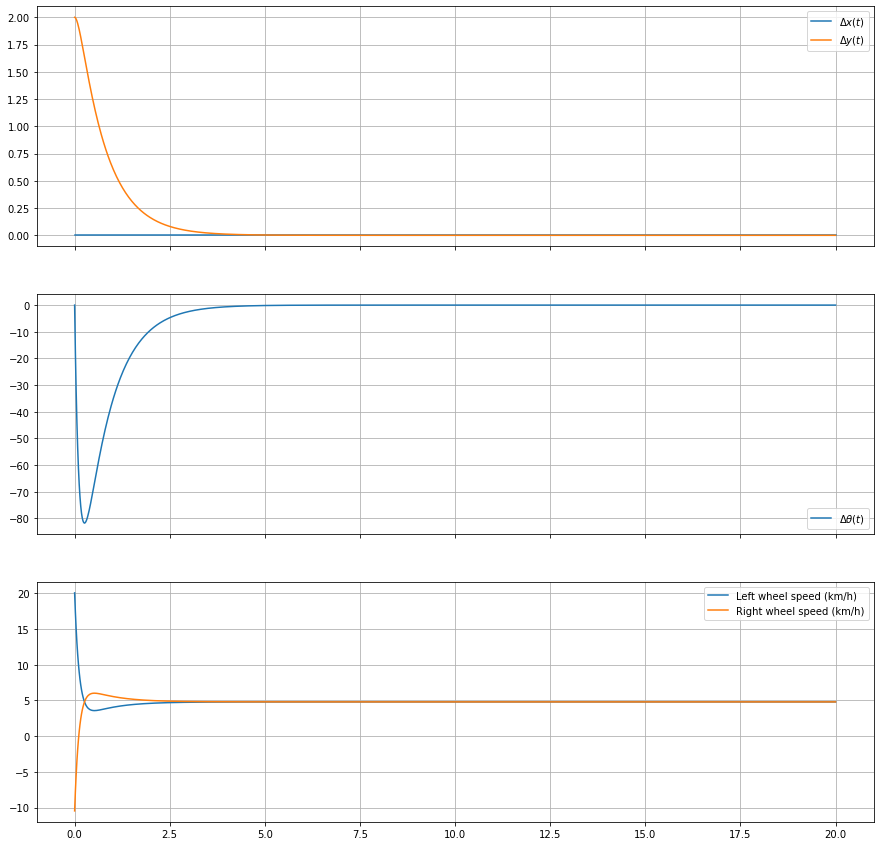

In [32]:
tf = 20
def deltaOmega(t,deltaX):
    return -K@deltaX
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l +v/Rw
omega_r = dOmega_r +v/Rw

ax3.plot(t,omega_l*Rw*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t,omega_r*Rw*3.6, label=r"Right wheel speed (km/h)")
ax3.legend()
ax3.grid()



In [33]:
# Large R0
Q=([[1,0,0],[0,1,0],[0,0,1]])
R0=[[100,0],[0,100]]
S = linalg.solve_continuous_are(A, B, Q, R0)
K = inv(R0) @ B.T @ S
eigenvalues, _ = eig(A - B @ K)
print(K)

[[ 0.07071068 -0.07071068 -0.40265971]
 [ 0.07071068  0.07071068  0.40265971]]


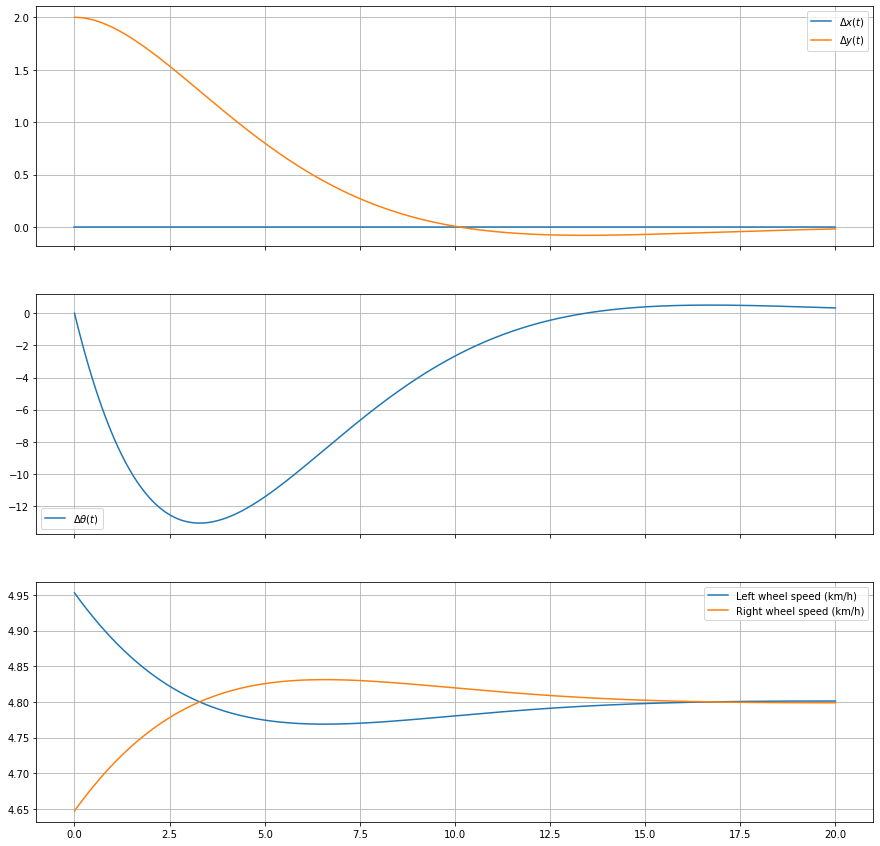

In [34]:
tf = 20
def deltaOmega(t,deltaX):
    return -K@deltaX
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l +v/Rw
omega_r = dOmega_r +v/Rw

ax3.plot(t,omega_l*Rw*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t,omega_r*Rw*3.6, label=r"Right wheel speed (km/h)")
ax3.legend()
ax3.grid()



[[ 0.09128709 -0.09128709 -0.45955798]
 [ 0.09128709  0.09128709  0.45955798]]


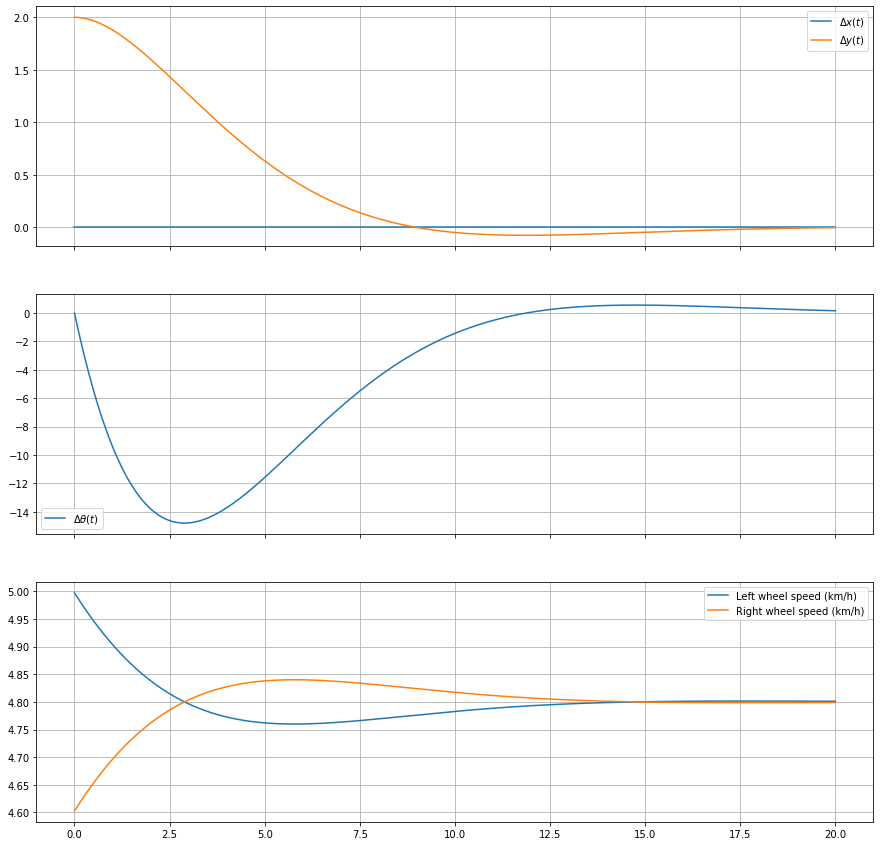

In [35]:
# Optimization
Q=([[1,0,0],[0,1,0],[0,0,1]])
R0=[[60,0],[0,60]]
S = linalg.solve_continuous_are(A, B, Q, R0)
K = inv(R0) @ B.T @ S
eigenvalues, _ = eig(A - B @ K)
print(K)

tf = 20
def deltaOmega(t,deltaX):
    return -K@deltaX
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l +v/Rw
omega_r = dOmega_r +v/Rw

ax3.plot(t,omega_l*Rw*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t,omega_r*Rw*3.6, label=r"Right wheel speed (km/h)")
ax3.legend()
ax3.grid()



### Controller validation

The goal of this part is to test the controller on the **true** non linear system.

We are going to simulate the original `fun` function, but to do this, we need to define a new version of the function `omega` that computes the wheel velocities given `t` and `xytheta` (the value of the state at time `t`).
    
🧩 Implement this new version of `omega`.

In [36]:
def omega(t,xytheta):
    Xr=array([v*t,0,0])
    omegaR=array([v/Rw,v/Rw])
    deltaX=xytheta-Xr
    deltaOmega= -K@deltaX
    omega= omegaR+deltaOmega
    return omega


🧩 Simulate the true system during 20 sec using the pole placement controller designed during the 'Controller Tuning'.

In [37]:

tf = 20
v = 5/ 3.6
t = linspace(0.0,tf, 1000)


def fun(t, xytheta):
    x,y, theta= xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = Rw * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = Rw * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = Rw * (omega_r - omega_l) / L
    return array([dx, dy, dtheta])




🧩 Plot $x(t)$, $y(t)$, $\theta(t)$, $\omega_l(t)$ and $\omega_r(t)$.

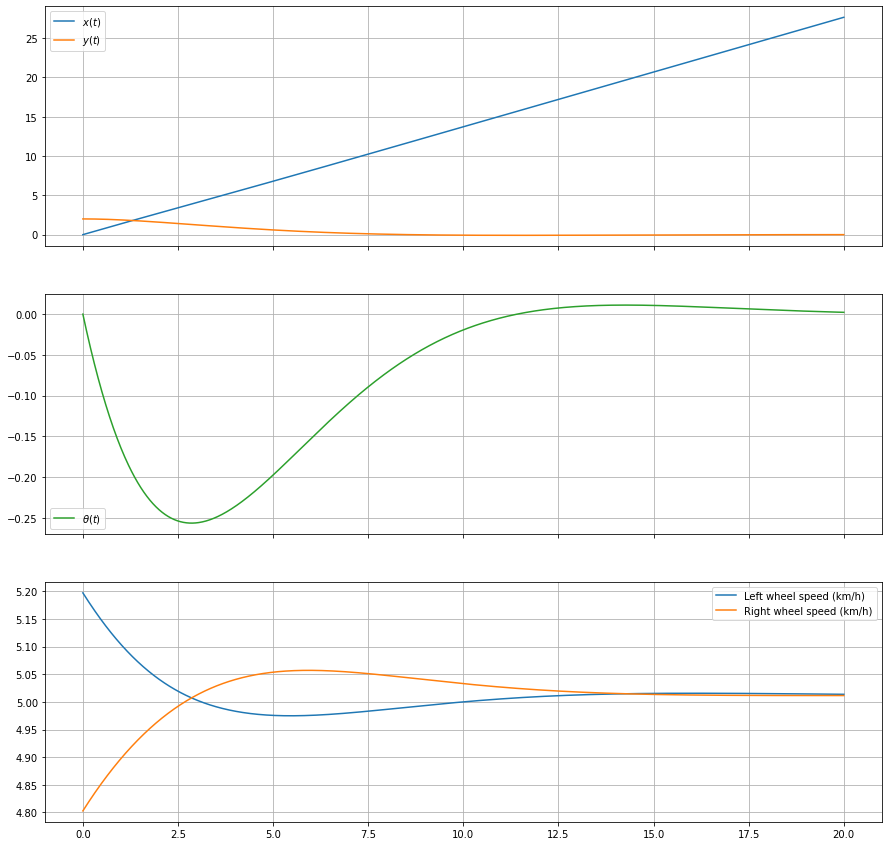

In [38]:
rn = solve_ivp(fun=fun,t_span=[0,tf] ,y0=[0,2,0], dense_output=True,rtol=1e-6, atol=1e-12)
t = linspace(0.0, 20, 1000)
xytheta=rn["sol"](t)
x, y, theta = xytheta

fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
Xr=np.zeros((3,1000))
Xr[0]=array([v*t])
deltaX=xytheta-Xr
dOmega= -K@deltaX
# print(Xr)
# print(len(Xr))
# print(len(rn['sol'](t)))
# print(rn['sol'](t))

deltaX=xytheta-Xr
dOmega= -K@deltaX
# dOmega= -K@xytheta
omegaR=array([v/Rw,v/Rw])

omega_l = dOmega[0,:]
omega_r = dOmega[1,:]



ax3.plot(t, (omega_l + omegaR[0]) *Rw* 3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t, (omega_r + omegaR[1]) *Rw* 3.6, label=r"Right wheel speed (km/h)")
grid()
legend()


🧩 Use the simulation results to display the wheelchair location every 1 second.

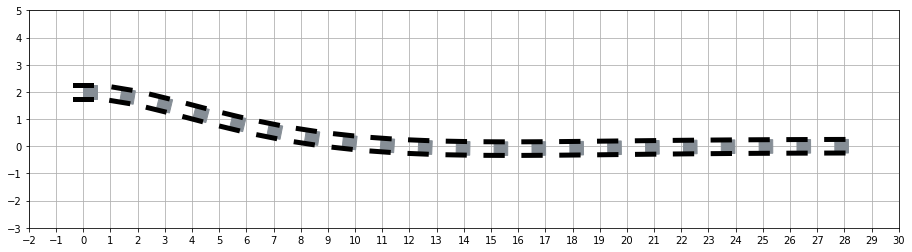

In [39]:
t = linspace(0,tf,tf+1)
sol1= rn["sol"](t)
draw_arena(xmax=30,xmin=-2,ymin=-3,ymax=5)
for x, y, theta in sol1.T:
    draw_wheelchair(x, y, theta)

🧩 Make a similar drawing but add to the wheelchair real location the wheelchair reference location in the background; use the blue color to represent this "virtual" weelchair.

In [40]:
def draw_virtual_wheelchair(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)], 
        [sin(theta),  cos(theta)]
    ])

    # Seat
    corners = [[0, -L/2], [L, -L/2], [L, +L/2], [0, L/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="#868e96", zorder=10)
    
    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-Rw], [-L/2]] + translation 
    wheel_left_xy_end = rotation @ [[Rw], [-L/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="blue",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-Rw], [+L/2]] + translation
    wheel_right_xy_end = rotation @ [[Rw], [L/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="blue", linewidth=5, zorder=20)
    

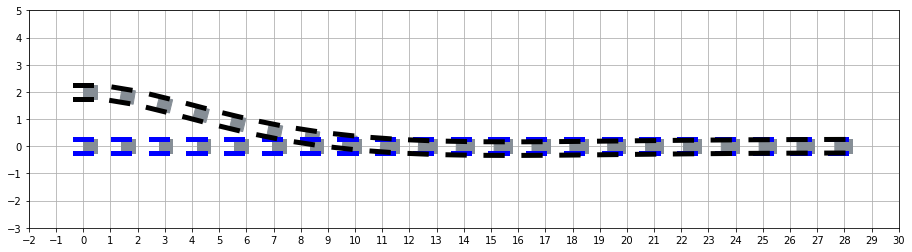

In [41]:
t = linspace(0,tf,tf+1)
sol1= rn["sol"](t)
draw_arena(xmax=30,xmin=-2,ymin=-3,ymax=5)

x_v=[v*i for i in t]
y_v=np.zeros(tf)
theta_v=np.zeros(tf)

for x in x_v:
    for y in y_v:
        for theta in theta_v:
            draw_virtual_wheelchair(x, y, theta)
for x, y, theta in sol1.T:
    draw_wheelchair(x, y, theta)


🧩 We now aim to compare the different control strategies. We consider the pole placement strategy and two optimal controllers (one with a large $Q$ and one with a large $R$). Run the simulations with the these extreme controllers, then with the controller that met the design constraints when tested on the linear model. Adjust slightly the parameters of the latter model if the constraints are not met anymore, so that they are met again.

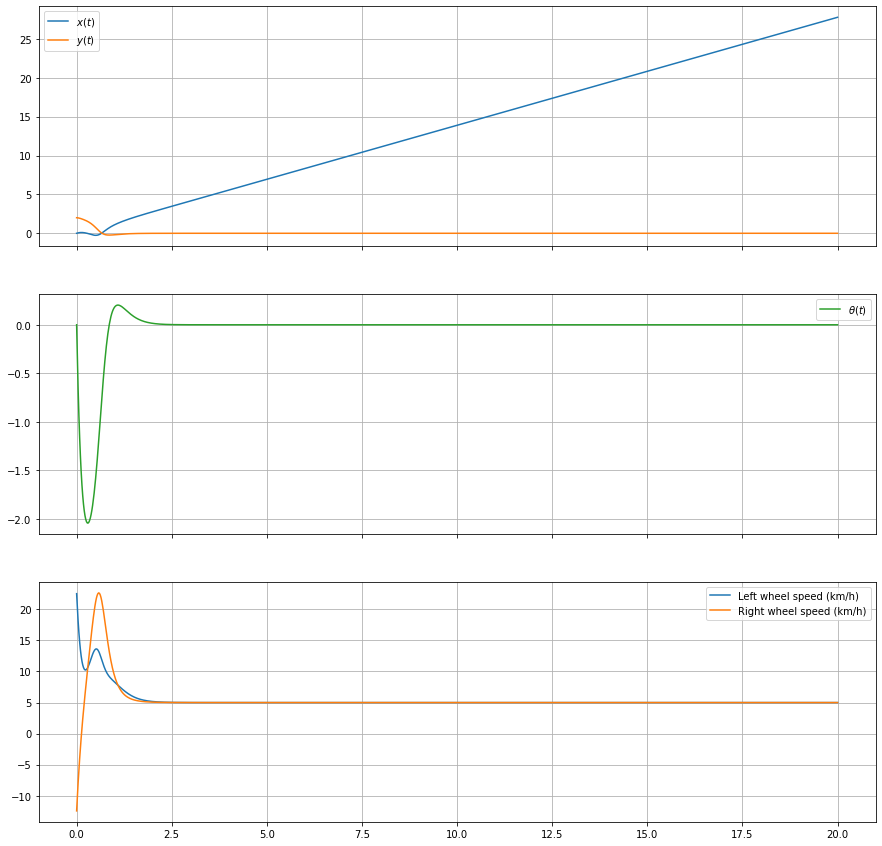

In [42]:

tf = 20
t = linspace(0.0,tf, 1000)

#Cas 1: pole placement
poles=new_poles
K = place_poles(A,B,poles).gain_matrix
rn = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
t = linspace(0.0, 20, 1000)
xytheta=rn["sol"](t)
x, y, theta = xytheta
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()

Xr=np.zeros((3,1000))
Xr[0]=array([v*t])
deltaX=xytheta-Xr
dOmega= -K@deltaX
# dOmega= -K@xytheta
omegaR=array([v/Rw,v/Rw])

omega_l = dOmega[0,:]
omega_r = dOmega[1,:]



ax3.plot(t, (omega_l + omegaR[0]) * Rw*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t, (omega_r + omegaR[1]) * Rw*3.6, label=r"Right wheel speed (km/h)")
grid()
legend()


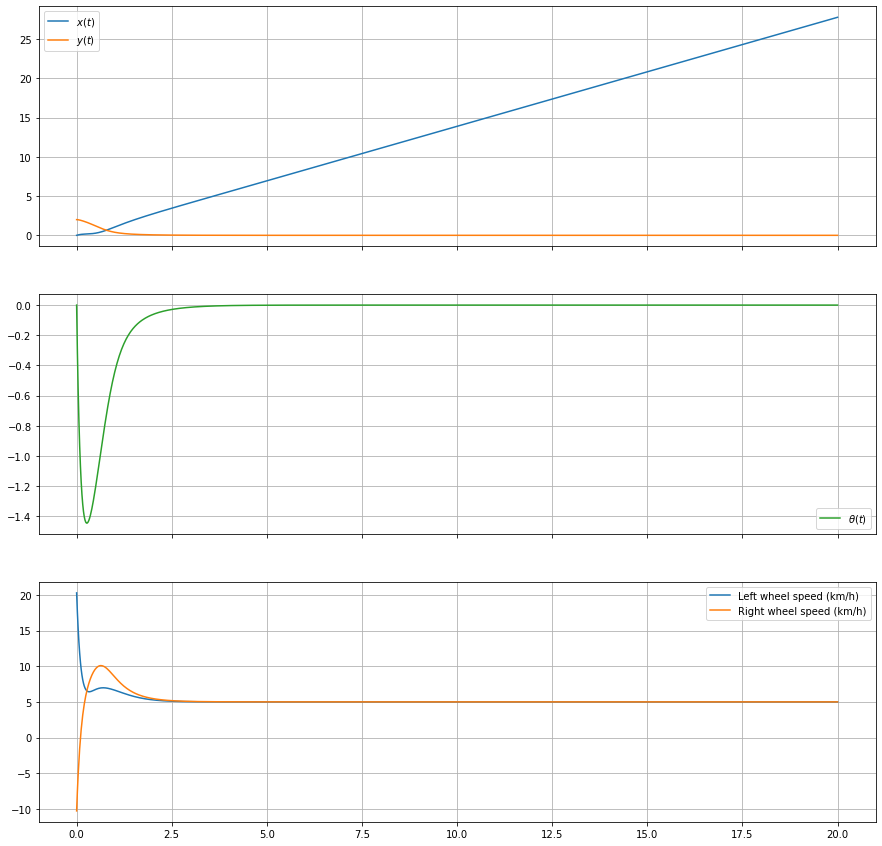

In [43]:
# large Q

R0=[[1,0],[0,1]]

QL=[[100,0,0],[0,100,0],[0,0,100]]
S = linalg.solve_continuous_are(A, B, QL, R0)
K_QL = inv(R0) @ B.T @ S



K=K_QL
r1 = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)


t = linspace(0.0, 20, 1000)
xytheta=r1["sol"](t)
x, y, theta = xytheta
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
Xr=np.zeros((3,1000))
Xr[0]=array([v*t])
deltaX=xytheta-Xr
dOmega= -K@deltaX

# dOmega= -K@xytheta
omegaR=array([v/Rw,v/Rw])

omega_l = dOmega[0,:]
omega_r = dOmega[1,:]



ax3.plot(t, (omega_l + omegaR[0]) *Rw* 3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t, (omega_r + omegaR[1]) *Rw* 3.6, label=r"Right wheel speed (km/h)")
grid()
legend()




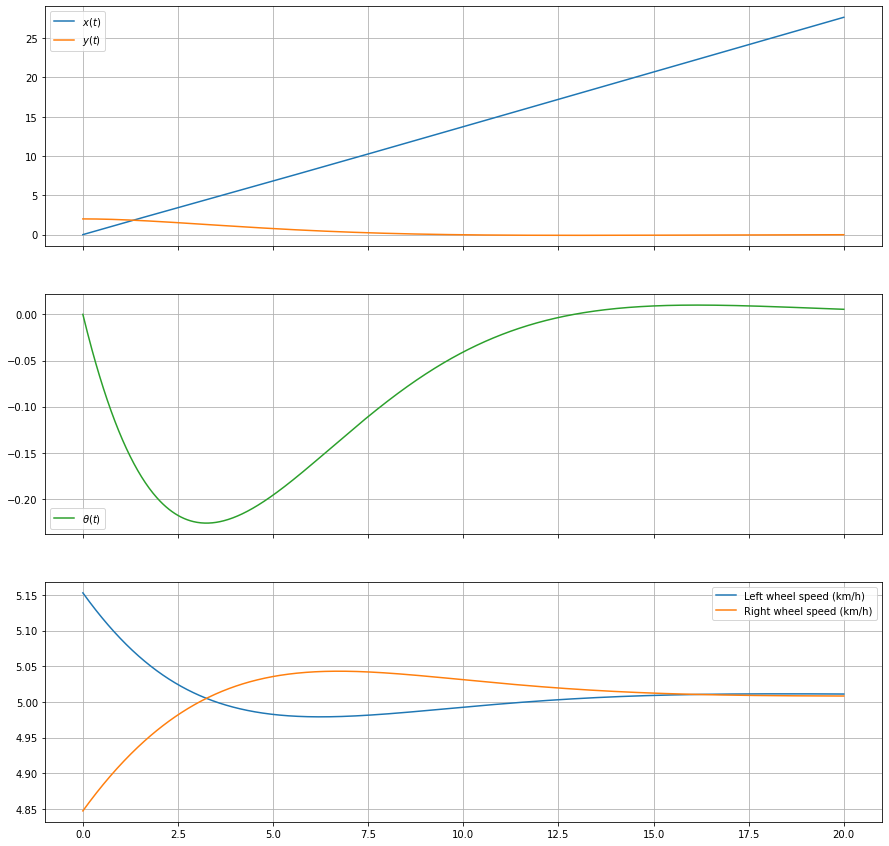

In [44]:
#  large R
Q=[[1,0,0],[0,1,0],[0,0,1]]
R0L=[[100,0],[0,100]]
S = linalg.solve_continuous_are(A, B, Q, R0L)
K_R0L = inv(R0L) @ B.T @ S
K=K_R0L
r2 = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
t = linspace(0.0, 20, 1000)
xytheta=r2["sol"](t)
x, y, theta = xytheta
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
Xr=np.zeros((3,1000))
Xr[0]=array([v*t])
deltaX=xytheta-Xr
dOmega= -K@deltaX

# dOmega= -K@xytheta
omegaR=array([v/Rw,v/Rw])

omega_l = dOmega[0,:]
omega_r = dOmega[1,:]



ax3.plot(t, (omega_l + omegaR[0]) * Rw*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t, (omega_r + omegaR[1]) * Rw*3.6, label=r"Right wheel speed (km/h)")
grid()
legend()


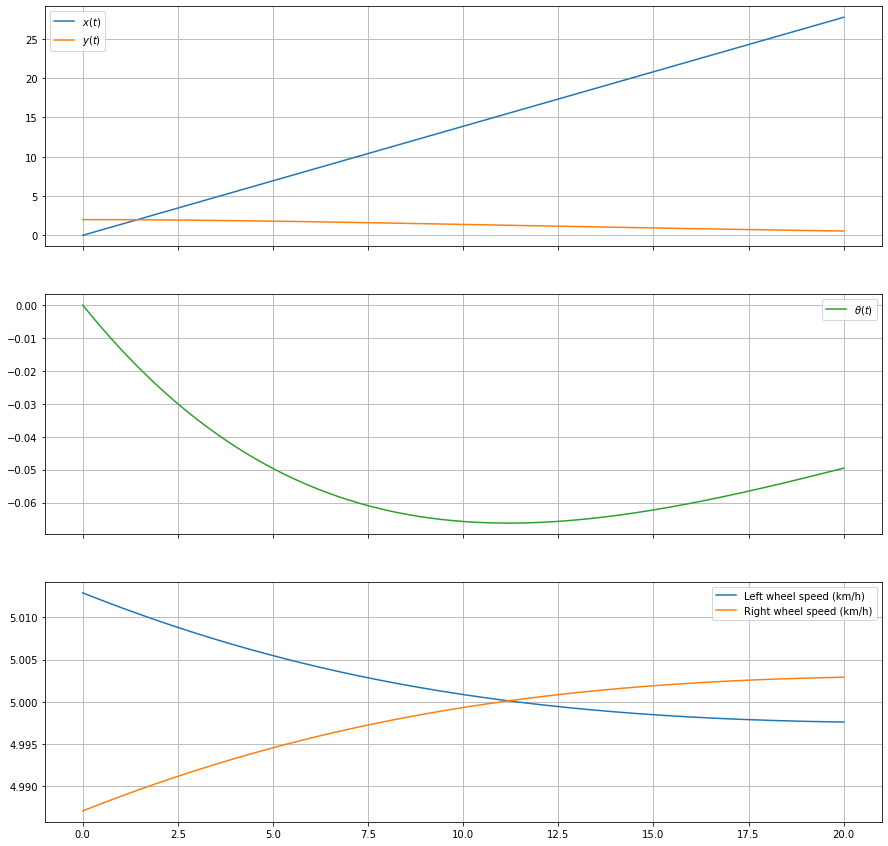

In [45]:
# Optimisation

QO=([[0.05,0,0],[0,0.05,0],[0,0,0.05]])
R0O=[[700,0],[0,700]]
S = linalg.solve_continuous_are(A, B, QO, R0O)
K_O = inv(R0O) @ B.T @ S


K=K_O
r3 = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)


t = linspace(0.0, 20, 1000)
xytheta=r3["sol"](t)
x, y, theta = xytheta
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()

Xr=np.zeros((3,1000))
Xr[0]=array([v*t])
deltaX=xytheta-Xr
dOmega= -K@deltaX
# dOmega= -K@xytheta
omegaR=array([v/Rw,v/Rw])

omega_l = dOmega[0,:]
omega_r = dOmega[1,:]



ax3.plot(t, (omega_l + omegaR[0]) *Rw* 3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t, (omega_r + omegaR[1]) *Rw* 3.6, label=r"Right wheel speed (km/h)")
grid()
legend()



🧩 Your wheelchair faces some strong wind (constant speed). How can you model the effect of this wind? Show the impact on the performance of your controller (with your controller of your choice).

Si on suppose que le vent est dans la direction (Ox). On pourrait ajouter un terme de vitesse de vent $v'$ à l'expression de $\dot{x}$
$$
\begin{array}{rcl}
\dot{x} &=& R_w  \frac{\omega_l + \omega_r}{2} \cos \theta + v' \\
\dot{y} &=& R_w  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R_w  \frac{\omega_r - \omega_l}{L} \\
\end{array}
$$

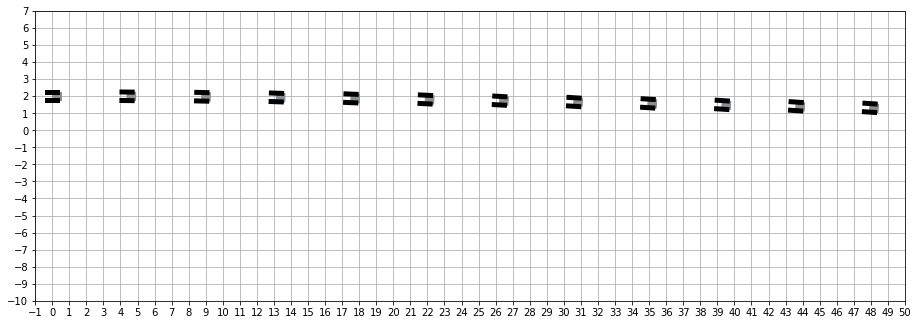

In [63]:
def fun(t, xytheta):
    x, y, theta = xytheta
    v_prime=3
    omega_l, omega_r = omega(t, xytheta)
    dx = Rw * 0.5 * (omega_l + omega_r) * cos(theta) + v_prime
    
    dy = Rw * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = Rw * (omega_r - omega_l) / L
    return array([dx, dy, dtheta])



r_vent = solve_ivp(fun=fun,t_span=[0,tf] ,y0=[0,2,0], dense_output=True,max_step=1e-2, atol=1e-12)
    

t = linspace(0,tf,tf+1)
sol_vent = r_vent["sol"](t)
draw_arena(xmax=50,xmin=-1,ymin=-10,ymax=7)
for x, y, theta in sol_vent.T:
    draw_wheelchair(x, y, theta)


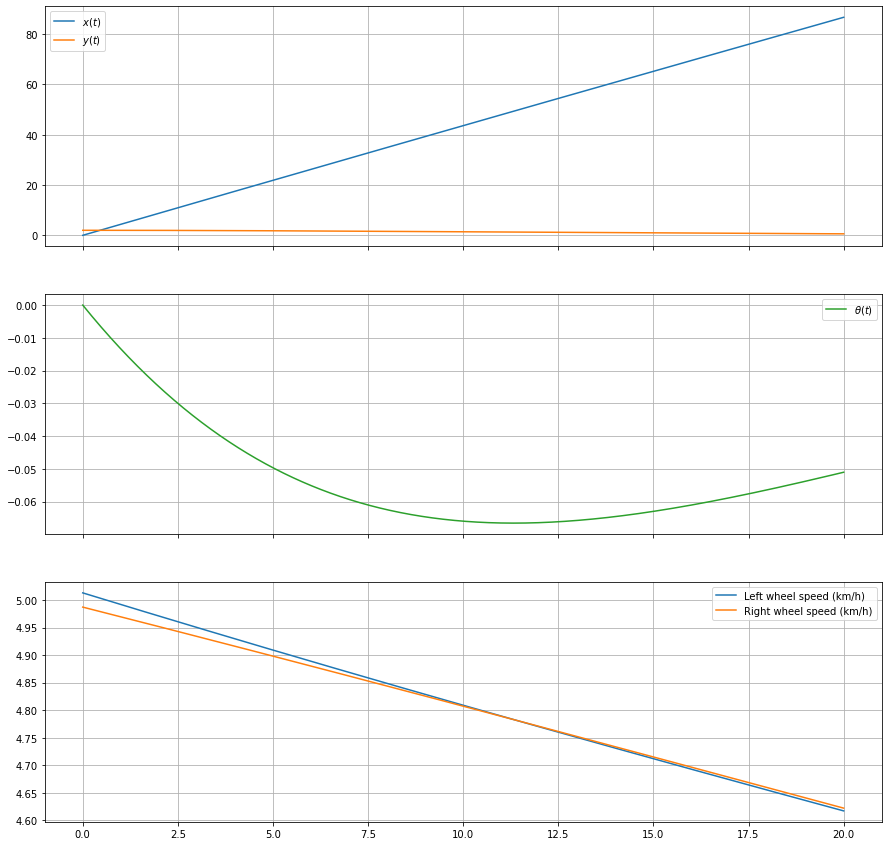

In [64]:
QO=([[0.05,0,0],[0,0.05,0],[0,0,0.05]])
R0O=[[700,0],[0,700]]
S = linalg.solve_continuous_are(A, B, QO, R0O)
K_O = inv(R0O) @ B.T @ S


K=K_O



t = linspace(0.0, 20, 1000)
xytheta=r_vent["sol"](t)
x, y, theta = xytheta
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()

Xr=np.zeros((3,1000))
Xr[0]=array([v*t])
deltaX=xytheta-Xr
dOmega= -K@deltaX
# dOmega= -K@xytheta
omegaR=array([v/Rw,v/Rw])

omega_l = dOmega[0,:]
omega_r = dOmega[1,:]



ax3.plot(t, (omega_l + omegaR[0]) *Rw* 3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t, (omega_r + omegaR[1]) *Rw* 3.6, label=r"Right wheel speed (km/h)")
grid()
legend()

🧩 What happens if the controller brutally stops at t=10s?

#### Answer

La chaise va continuer de rouler avec la meme vitesse sur la meme trajectoire. Pourtant, le systeme va avancer suivant une maniere non-lineaire.

🧩 What if additionally to the initial position mismatch the wheelchair starts with a wrong orientation (say $\theta=\pi/2$)?

#### Answer

La chaise n'avancera pas vers sa position désirée et va se diriger vers le haut, augmentant l'erreur. On aura besoin de corriger les parametres de la control law.

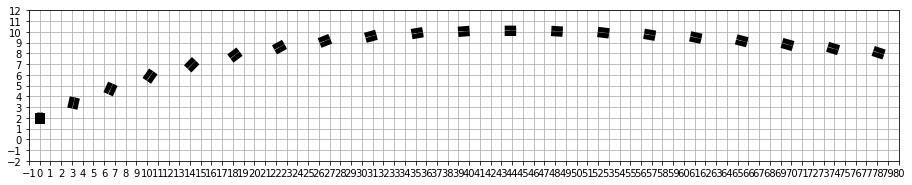

In [68]:
r_vent = solve_ivp(fun=fun,t_span=[0,tf] ,y0=[0,2,pi/2], dense_output=True,max_step=1e-2, atol=1e-12)
    

t = linspace(0,tf,tf+1)
sol_vent = r_vent["sol"](t)
draw_arena(xmax=80,xmin=-1,ymin=-2,ymax=12)
for x, y, theta in sol_vent.T:
    draw_wheelchair(x, y, theta)

###  Feet Dynamics

The person in the wheelchair now tries to control its vehicle by targetting only where should be the location between its feet ($M=20$ cm in front of the weelchair seet) without any regard for the wheelchair angle.

🧩 Write the coordinates $(x_f, y_f)$ of this location as a function of $x$, $y$ and $\theta$. 

**Answer:**

Les coordonnées ($x_f, y_f$) s'écrivent : 

$x_f(t) = x(t) + (\frac{L}{2}+M)cos(\theta)$

$y_f(t) = y(t) + (\frac{L}{2}+M)sin(\theta)$ 


🧩 Write the differential equation satisfied by $(x_f, y_f)$. 

**Answer:**

On dérive les équations de la question précedente, on obtient:

$\dot{x}_n= \frac{R_w}{2}cos(\theta)(\omega_r +\omega_l) - \dot{\theta}(\frac{L}{2}+M)sin(\theta)  \Leftrightarrow \dot{x}_n= \frac{R_w}{2}cos(\theta)(\omega_r +\omega_l) -R_w\frac{(\omega_r -\omega_l)}{L}(\frac{L}{2}+M)sin(\theta)$

Donc : 
$ \dot{x}_n=\frac{R_w}{2}cos(\theta)(\omega_r +\omega_l) -R_w(\omega_r -\omega_l)(\frac{1}{2}+\frac{M}{L})sin(\theta)$

Et : 

$\dot{y}_n= \frac{R_w}{2}sin(\theta)(\omega_r +\omega_l) + \dot{\theta}(\frac{L}{2}+M)cos(\theta) \Leftrightarrow  \dot{y}_n= \frac{R_w}{2}sin(\theta)(\omega_r +\omega_l) + Rw\frac{(\omega_r -\omega_l)}{L}(\frac{L}{2}+M)cos(\theta) $

Donc : 
$ \dot{y}_n=\frac{R_w}{2}sin(\theta)(\omega_r +\omega_l)+R_w(\omega_r -\omega_l)(\frac{1}{2}+\frac{M}{L})cos(\theta)$

🧩 Show any (smooth) reference evolution of the person feet $(x_f^r(t), y_f^r(t))$ and any initial state of the wheelchair consistent with the initial feet location, there is an admissible trajectory $(x(t), y(t), \theta(t))$ that corresponds to this reference. Hint: search the unique $\omega_l(t)$ and $\omega_r(t)$ -- as functions of $\dot{x}_f^r(t)$, $\dot{y}_f^r(t)$ and $\theta(t)$ -- that satisfies this property. 

**Answer:**

On résout le système diff précédent pour trouver $\omega_r \space et \space \omega_l$

Après calcul, nous obtenons :

$ \omega_r = \frac{1}{R_w}[\dot{y}_ncos(\theta) + \dot{x}_nsin(\theta)]   $

$ \omega_l = \frac{1}{R_w}[\dot{y}_ncos(\theta) - \dot{x}_nsin(\theta)] $

Soit T = $(x_n,y_n)$ une trajectoire. $x_n,y_n$ sont dérivables, donc en combinant avec l'angle de rotation $\theta$ nous pouvons construire des vitesses $\omega_r \space et \space \omega_l$ nous permettant de parcourir parfaitement cette trajectoire. 
On conclut donc que pour toute évolution de référence (smooth) des pieds de la personne ($x_rn(t),y_rn$(t)) et tout état initial du robot consistant avec l'emplacement initial des pieds, il existe une trajectoire admissible (𝑥(𝑡),𝑦(𝑡 ),𝜃(𝑡)) qui correspond à cette référence, il suffit de choisir correctement les vitesses de rotation des roues droite et gauche. 


🧩 Let $v>0$ be the value in m/s that corresponds to $4.8$ km/h and let $(x_f^r(t), y_f^r(t)) = (vt, 0)$.
Simulate the wheelchair evolution with the choice for $\omega_l$ and $\omega_r$ of the previous question for $X(0) = (-L-M, 0, 0)$. Represent the wheelchair every second with an extra dot for the feet location.

Then, try the simulation with 
$$
X(0) = (-(L+M)\cos(\alpha), -(L+M)\sin(\alpha),\alpha)
$$ 
for different values of $\alpha = \theta(0)$. In particular, investigate the case of à $\theta(0)$ close to $0$, then close to $\pi$). Is the system dynamics asymptotically stable in each case?

<ipython-input-72-1cc20f743b01>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plot(ts, xs, "k",color='green',label=r'$x(t)$')
<ipython-input-72-1cc20f743b01>:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plot(ts, ys, "k",color='red',label=r'$y(t)$')
<ipython-input-72-1cc20f743b01>:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plot(ts, thets, "k",color='yellow',label=r'$theta(t)$')


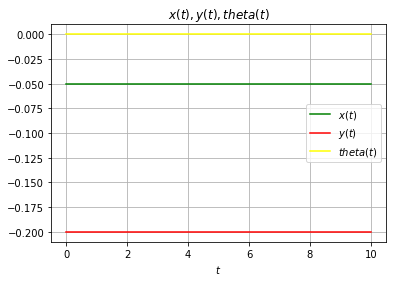

In [72]:
from math import degrees as deg
from math import radians as rad

v = 4.8/3.6
M = 0.2

xn0 = -L
yn0 = -M
theta0 = 0

x0 = xn0 + (L/2+M) * cos(theta0)
y0 = yn0 + (L/2+M) * sin(theta0)
tf = 10
X0 = array([x0, y0, theta0])

def f2(t, X):
    x, y, theta = X
    
    xn_r = v*t
    d_xn_r = v
    
    yn_r = 0
    d_yn_r = 0
    
    omega_l = 1/Rw*(d_yn_r*cos(theta) - (d_xn_r * sin(theta)))
    omega_r = 1/Rw*(d_yn_r*cos(theta) + (d_xn_r * sin(theta)))
    
    dtheta = (Rw/L) * (omega_r - omega_l)
    dx = (Rw/2) * (omega_l + omega_r) * cos(theta)
    dy = (Rw/2) * (omega_l + omega_r) * sin(theta)
    
    dX = array([dx, dy, dtheta])
    return dX

res = solve_ivp(f2, [0.0, tf], X0, dense_output = True, max_step = 1e-2)

ts = res["t"]
xs = res["y"][0]
ys = res["y"][1]
thets = res["y"][2]

figure()
plot(ts, xs, "k",color='green',label=r'$x(t)$')
plot(ts, ys, "k",color='red',label=r'$y(t)$')
plot(ts, thets, "k",color='yellow',label=r'$theta(t)$')
grid(True); xlabel("$t$"); title("$x(t), y(t), theta(t)$")

legend()
show()


<ipython-input-75-530906b7cde8>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plot(ts, xs, "k",color='green',label=r'$x(t)$')
<ipython-input-75-530906b7cde8>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plot(ts, ys, "k",color='red',label=r'$y(t)$')
<ipython-input-75-530906b7cde8>:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plot(ts, thets, "k",color='yellow',label=r'$theta(t)$')


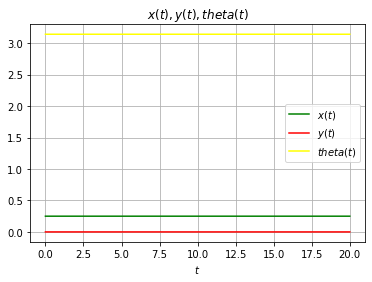

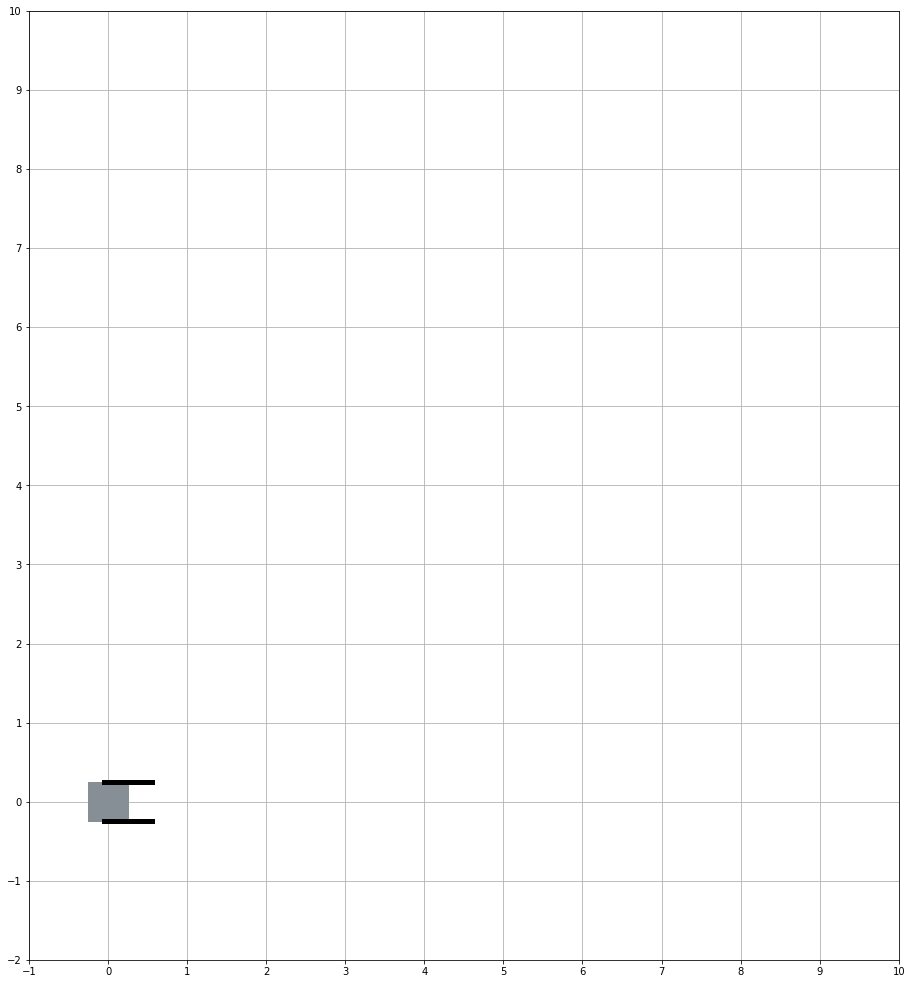

In [75]:
#2e cas
from math import degrees as deg
from math import radians as rad

v = 4.8/3.6
M = 0.2
tf=20
t = linspace(0,tf,1000)
theta0 = pi
xn0 = -(L+M)*cos(theta0)
yn0 = -(L+M)*sin(theta0)


x0 = xn0 + (L/2+M) * cos(theta0)
y0 = yn0 + (L/2+M) * sin(theta0)

X0 = array([x0, y0, theta0])

def f2(t, X):
    x, y, theta = X
    
    xn_r = v*t
    d_xn_r = v
    
    yn_r = 0
    d_yn_r = 0
    
    omega_l = 1/Rw*(d_yn_r*cos(theta) - (d_xn_r * sin(theta)))
    omega_r = 1/Rw*(d_yn_r*cos(theta) + (d_xn_r * sin(theta)))
    
    dtheta = (Rw/L) * (omega_r - omega_l)
    dx = (Rw/2) * (omega_l + omega_r) * cos(theta)
    dy = (Rw/2) * (omega_l + omega_r) * sin(theta)
    
    dX = array([dx, dy, dtheta])
    return dX

res = solve_ivp(f2, [0.0, tf], X0, dense_output = True, max_step = 1e-2)

ts = res["t"]
xs = res["y"][0]
ys = res["y"][1]
thets = res["y"][2]

figure()
plot(ts, xs, "k",color='green',label=r'$x(t)$')
plot(ts, ys, "k",color='red',label=r'$y(t)$')
plot(ts, thets, "k",color='yellow',label=r'$theta(t)$')
grid(True); xlabel("$t$"); title("$x(t), y(t), theta(t)$")

legend()
show()
t = linspace(0,tf,tf+1)
sol_2 = res["sol"](t)
draw_arena(xmax=10,xmin=-1,ymin=-2,ymax=10)
for x, y, theta in sol_2.T:
    draw_wheelchair(x, y, theta)

 Oui, le système est considéré stable car il est en état d'équilibre

🧩 Consider three pillars (of small radius) whose centers are aligned and distant of 2 meters, say at the locations
$$
(1.0,0), (3.0, 0) \mbox{ and } (5.0,0).
$$
Compute a reference trajectory trajectory that would lead the feetfrom $(0,0)$ to $(6,0)$ with a slalom between the pillars. Of course, you don't want the robot frame to bump into the pillars ! Display this trajectory graphically. What happens when if the inputs $\omega_l(t)$ and $\omega_r(t)$ are applied but the robot is not initially at the expected position ?

**Answer:**

In [51]:
pass